In [1]:
# from lfs_tree import *
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)
import pydot
import networkx as nx
from string import Template
import pandas as pd
import glob
import pydot
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
import seaborn as sns

from IPython.display import Image, display
import matplotlib.pyplot as plt
# from IPython.display import Image, display

# the graphs this script will generate:
## 1. local quality:
            x:  deletion_factor: fix user_input_size
            x:  complaint_ratio: fix user_input_size
            y:  fix rate + confirm preserve rate + global accuracy (before after)
## 2.3 strat comparison:
      x: user input size (fix complaint ratio, fix deletion factor)
      y: runtime, global_accuracy, fix rate, confirm preserve rate

In [2]:
line_color_assignment_dict={'naive':'g','information_gain':'r', 'optimal': 'b'}

In [3]:
# functions

def view_pydot(pdot):
    plt = Image(pdot.create_png())
    display(plt)

def show_trees(directory):
    treefiles = glob.glob(f'{directory}*tree_*')
    print(treefiles)
    for f in treefiles:
        file = open(f)
        dot_string = file.read()
        print(f)
#             print(dot_string)
        graph = pydot.graph_from_dot_data(dot_string)[0]
        view_pydot(graph)
        print('\n')
            
def show_stats(directory):
    fs = glob.glob(f'{directory}*/*experiment_stats')
    df = pd.concat([pd.read_csv(f) for f in fs])
    return df

def determine_shape(x, shape_assignment_dict):
    return shape_assignment_dict[x]

def determine_color(x, color_assignment_dict):
    return color_assignment_dict[x]

def scatter_plots(df, x, y, xlabel, ylabel, title, shape_assignment_dict, color_assignment_dict,
                 first_legend_pos, second_legend_pos, strat_legend_rel_pos, ratio_legend_re_pos):
        
    fig, ax = plt.subplots()
    groups = df.groupby(['strat','complaint_ratio'])
    # Create a scatter plot for each group based on shape and color
    for (strat, ratio), group in groups:
        marker = shape_assignment_dict.get(strat)
        color=color_assignment_dict.get(ratio)
        ax.scatter(group[x], group[y], marker=marker, color=color, label=(strat, ratio))

    # Create separate shape and color legends
    legend_elements_1 = []
    legend_elements_2 = []

    for shape, marker in shape_assignment_dict.items():
        legend_elements_1.append(plt.Line2D([0], [0], marker=marker, color='w', label=shape, markerfacecolor='k'))
    for ratio, color in color_assignment_dict.items():
        legend_elements_2.append(plt.Line2D([0], [0], marker='o', color='w', label=ratio, markerfacecolor=color))

    # Add shape and color legends
    first_legend=ax.legend(handles=legend_elements_1, loc=first_legend_pos, 
                           bbox_to_anchor=strat_legend_rel_pos,
                           title='strategy', 
                           fontsize=13,title_fontsize=14)
    ax.legend(handles=legend_elements_2, loc=second_legend_pos, 
              bbox_to_anchor=ratio_legend_re_pos, title='complaint%',
              fontsize=13, title_fontsize=14)

    ax.add_artist(first_legend)

    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)
    ax.set_title(title, fontsize=14)

    plt.show()
    plt.close(fig)
    

def scatter_plot_single_group_value(df, x, y, xlabel, ylabel, title, color_assignment_dict, group_col,
                                   scale, xticks=[], yticks=[]):
    fig, ax = plt.subplots()
    groups = df.groupby([group_col])
    for (g), group in groups:
        color = color_assignment_dict.get(g)
        ax.scatter(group[x], group[y], color=color, label=(g), s=10)  # Set linestyle to an empty string
    if(ylabel=='new_global_accuracy'):
        ax.plot(df[x], df['global_accuracy'], color='black', label='accuracy_before_fix')
    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)
    ax.set_title(title, fontsize=14)
    ax.set_yscale(scale)  # Set the y-axis to logarithmic scale
    if(yticks):
        ax.set_yticks(yticks)
    if(xticks):
        ax.set_xticks(xticks)
    # Customize y-axis ticks and labels
#     ax.set_yticks([0.1, 1, 10, 100])
#     ax.set_yticklabels(['10^-1', '10^0', '10^1', '10^2'])
    ax.legend(fontsize=13,title_fontsize=14)
    plt.savefig(f'graph_pdfs/{title}.pdf', format='pdf')
    
    plt.show()
    plt.close(fig)
    plt.show()
    plt.close(fig)

    
def line_plots(df, x, y, xlabel, ylabel, title, color_assignment_dict, legend_pos,
#                group_name,
#                group_value, 
               gtype='general',
               ylim=None,
              ):
    fig, ax = plt.subplots()
#     df=df[df[group_name]==group_value]
    # Create a scatter plot for each group based on shape and color
    groups = df.groupby(['strat'])
    for strat, group in groups:
        color = color_assignment_dict.get(strat)
        print(f'color: ')
        ax.plot(group[x], group[y], color=color, label=strat)
    if(gtype=='accuracy'):
        ax.plot(df[x], df['global_accuracy'], color='blue', label='accuracy_before_fix')
    ax.legend()
    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)
    ax.set_title(title, fontsize=14)
    if(ylim):
        ax.set_ylim(ylim)
    plt.savefig(f'graph_pdfs/{title}.pdf', format='pdf')
    plt.show()
    plt.close(fig)


def boxplot(df, x, y, xlabel, ylabel, title, yscale=[], xscale=[], yticks=[], xticks=[]):
    plt.figure(figsize=(8, 6))
    
    # Set the y-axis scale
    strat_list = list(df['strat'].unique())
    strat_list.sort()
        
    ax = sns.boxplot(data=df, x=x, y=y, hue='strat', hue_order=strat_list)
        # Change tick label font size for both x and y axes
    ax.tick_params(axis='both', labelsize=12)
    
    # Add a horizontal line at the specified y-coordinate (line_y)
    if ylabel == 'new_global_accuracy':
#     if line_y is not None:
        ax.axhline(y=float(df['global_accuracy'].unique()[0]), color='red', label='gloabl accuracy before fix',
                  linewidth=5)
        ax.legend(fontsize=14,title_fontsize=15)
        # Create a separate legend for the box plot (customize as needed)
        box_legend = ax.legend(title='Strat',fontsize=13,title_fontsize=15)
    
        # Combine the legends
        ax.add_artist(box_legend)
    else:
        # Create a separate legend for the box plot (customize as needed)
        ax.legend(title='Strat',fontsize=14,title_fontsize=15)
    if yscale:
        ax.set_yscale(yscale)
    
    if xscale:
        ax.set_xscale(xscale)
    
    if yticks:
        ax.set_yticks(yticks)
    
    if xticks:
        ax.set_xticks(xticks)

    plt.title(title,fontsize=20)
    plt.xlabel(xlabel,fontsize=14)
    plt.ylabel(ylabel,fontsize=14)

    plt.savefig(f"graph_pdfs/box_{title}.pdf", format="pdf")
    plt.show()



In [21]:
files=glob.glob('../experiment_results_folders/dc_test_case_1009/*/experiment_stats')

In [22]:
files

['../experiment_results_folders/dc_test_case_1009/20231010005343/experiment_stats',
 '../experiment_results_folders/dc_test_case_1009/20231010005440/experiment_stats',
 '../experiment_results_folders/dc_test_case_1009/20231010005530/experiment_stats',
 '../experiment_results_folders/dc_test_case_1009/20231010010113/experiment_stats']

In [23]:
df_stats = pd.concat([pd.read_csv(f) for f in files])

In [24]:
df_stats

,strat,semantic_version,populate_runtime,prefilter_runtime,rbbm_runtime,bbox_runtime,avg_tree_size_increase,user_input_size,complaint_ratio,num_complaints,num_confirmations,global_accuracy,fix_rate,confirm_preserve_rate,new_global_accuracy,prev_signaled_cnt,new_signaled_cnt,num_functions,deletion_factor,post_fix_num_funcs,num_of_funcs_processed_by_algo,complaint_reached_max,confirm_reached_max,lf_source,retrain_after_percent,retrain_accuracy_thresh,load_funcs_from_pickle,pre_deletion_threshold
0,naive,ind,41.937,0.108,0.023,0.594,2.571429,20,0.5,10,10,0.394,0.8,0.625,0.848,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,lf_only,0.0
0,information_gain,ind,37.835,0.083,0.084,0.448,0.571429,20,0.5,10,10,0.452,1.0,0.375,0.886,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,lf_only,0.0
0,naive,ind,52.324,0.120,0.021,0.775,2.285714,20,0.5,10,10,0.370,0.6,0.750,0.774,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,lf_only,0.0
0,optimal,ind,53.101,0.086,0.023,2.578,0.285714,20,0.5,10,10,0.372,0.1,0.778,0.478,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,lf_only,0.0


In [11]:
import pickle

In [14]:
with open('../experiment_results_folders/dc_test_case_1009/20231010005343/dcs_before_fix.pkl', 'rb') as f_dc_before_1:
    dc_before_1 = pickle.load(f_dc_before_1)

In [16]:
with open('../experiment_results_folders/dc_test_case_1009/20231010005440/dcs_before_fix.pkl', 'rb') as f_dc_before_2:
    dc_before_2 = pickle.load(f_dc_before_2)

In [17]:
dc_before_2

{0,
 1,
 3,
 5,
 6,
 7,
 9,
 10,
 11,
 15,
 18,
 24,
 25,
 26,
 30,
 31,
 32,
 33,
 34,
 37,
 38,
 39,
 41,
 42,
 43,
 46,
 48,
 49,
 52,
 54,
 56,
 58,
 59,
 60,
 62,
 63,
 64,
 65,
 67,
 69,
 71,
 72,
 77,
 79,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 96,
 98,
 99,
 101,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 111,
 113,
 115,
 117,
 124,
 125,
 126,
 127,
 128,
 131,
 133,
 135,
 136,
 137,
 139,
 140,
 144,
 146,
 148,
 149,
 150,
 151,
 152,
 153,
 155,
 156,
 157,
 158,
 160,
 161,
 162,
 163,
 164,
 166,
 167,
 169,
 170,
 171,
 173,
 174,
 176,
 177,
 178,
 180,
 182,
 184,
 185,
 191,
 194,
 195,
 198,
 199,
 203,
 204,
 207,
 208,
 210,
 212,
 214,
 215,
 216,
 217,
 219,
 221,
 222,
 223,
 224,
 226,
 228,
 230,
 231,
 232,
 233,
 235,
 236,
 237,
 238,
 239,
 240,
 241,
 244,
 245,
 248,
 252,
 253,
 254,
 255,
 256,
 257,
 259,
 264,
 265,
 268,
 270,
 273,
 274,
 277,
 280,
 283,
 286,
 287,
 290,
 293,
 296,
 297,
 298,
 301,
 302,
 306,
 308,
 309,
 312,
 313,
 

In [15]:
dc_before_1

{0,
 1,
 2,
 3,
 5,
 6,
 7,
 11,
 13,
 14,
 15,
 16,
 19,
 21,
 22,
 23,
 24,
 25,
 26,
 28,
 31,
 34,
 39,
 42,
 44,
 45,
 47,
 49,
 52,
 53,
 54,
 57,
 58,
 60,
 61,
 62,
 63,
 64,
 65,
 67,
 69,
 71,
 75,
 77,
 78,
 79,
 80,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 91,
 92,
 93,
 95,
 96,
 98,
 99,
 101,
 102,
 105,
 106,
 107,
 108,
 109,
 110,
 112,
 113,
 114,
 117,
 118,
 120,
 125,
 128,
 132,
 133,
 136,
 138,
 142,
 145,
 147,
 148,
 149,
 150,
 153,
 157,
 158,
 159,
 162,
 163,
 164,
 165,
 168,
 169,
 170,
 171,
 174,
 176,
 178,
 180,
 181,
 182,
 184,
 186,
 187,
 189,
 197,
 199,
 200,
 201,
 202,
 203,
 204,
 205,
 206,
 208,
 212,
 213,
 215,
 216,
 217,
 220,
 221,
 223,
 224,
 225,
 226,
 228,
 232,
 235,
 237,
 238,
 239,
 240,
 241,
 243,
 252,
 253,
 255,
 257,
 258,
 260,
 263,
 266,
 267,
 269,
 271,
 272,
 273,
 275,
 278,
 279,
 280,
 283,
 284,
 287,
 288,
 292,
 293,
 294,
 296,
 297,
 298,
 299,
 300,
 308,
 311,
 313,
 314,
 315,
 316,
 318,
 319,
 322,
 323,


In [18]:
dc_before_1==dc_before_2

False

In [19]:
len(dc_before_1)

1182

In [20]:
len(dc_before_2)

1055

In [25]:
df_naive = pd.read_csv('../experiment_results_folders/dc_test_case1004/20231010043455/user_input.csv')

In [27]:
df_stats = pd.read_csv('../experiment_results_folders/dc_test_case1004/20231010043455/experiment_stats')

In [28]:
df_stats

,strat,semantic_version,populate_runtime,prefilter_runtime,rbbm_runtime,bbox_runtime,avg_tree_size_increase,user_input_size,complaint_ratio,num_complaints,num_confirmations,global_accuracy,fix_rate,confirm_preserve_rate,new_global_accuracy,prev_signaled_cnt,new_signaled_cnt,num_functions,deletion_factor,post_fix_num_funcs,num_of_funcs_processed_by_algo,complaint_reached_max,confirm_reached_max,lf_source,retrain_after_percent,retrain_accuracy_thresh,load_funcs_from_pickle,pre_deletion_threshold
0,naive,ind,44.63,0.124,0.023,6.415,1.428571,20,0.5,10,10,0.507,0.8,0.2,0.849,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,lf_only,0.0


['../experiment_results_folders/dc_test_case1004/20231010043455/tree_1_dot_file', '../experiment_results_folders/dc_test_case1004/20231010043455/tree_2_dot_file', '../experiment_results_folders/dc_test_case1004/20231010043455/tree_3_dot_file', '../experiment_results_folders/dc_test_case1004/20231010043455/tree_4_dot_file', '../experiment_results_folders/dc_test_case1004/20231010043455/tree_5_dot_file', '../experiment_results_folders/dc_test_case1004/20231010043455/tree_6_dot_file', '../experiment_results_folders/dc_test_case1004/20231010043455/tree_7_dot_file']
../experiment_results_folders/dc_test_case1004/20231010043455/tree_1_dot_file


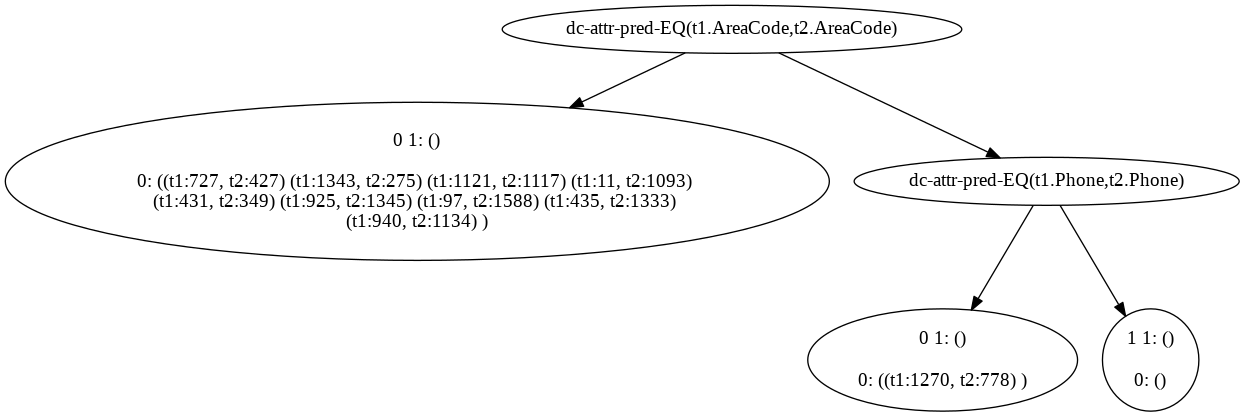



../experiment_results_folders/dc_test_case1004/20231010043455/tree_2_dot_file


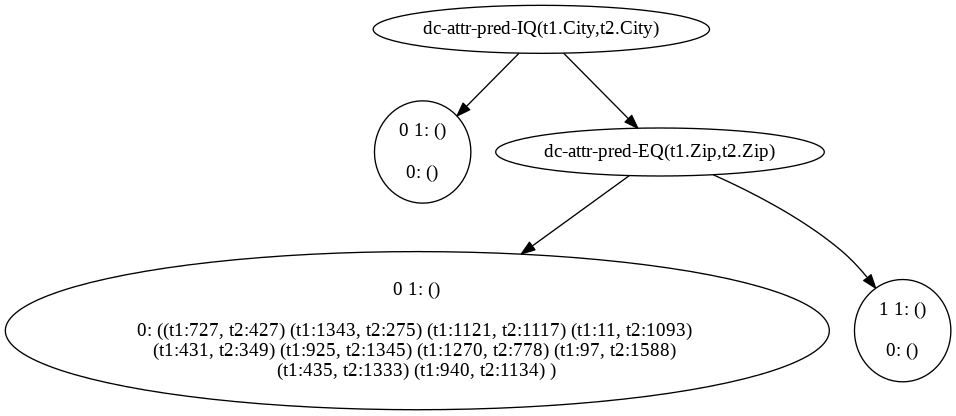



../experiment_results_folders/dc_test_case1004/20231010043455/tree_3_dot_file


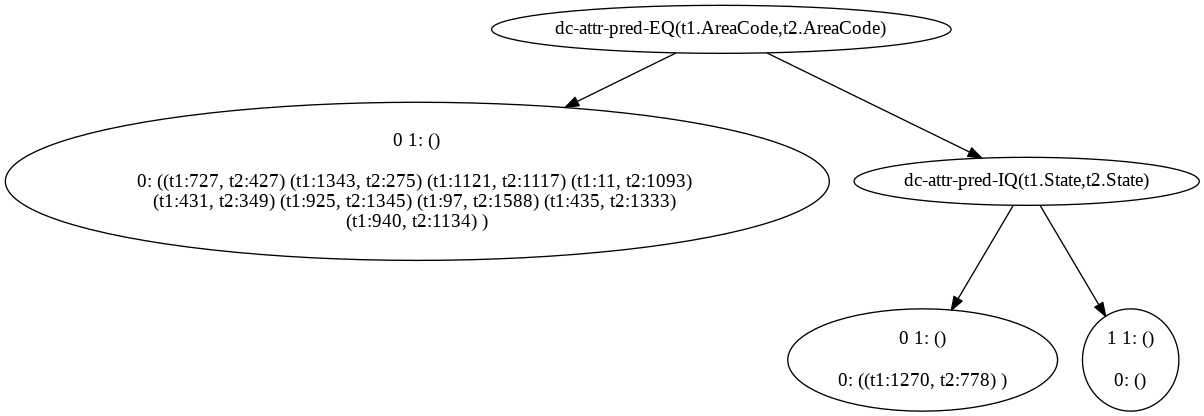



../experiment_results_folders/dc_test_case1004/20231010043455/tree_4_dot_file


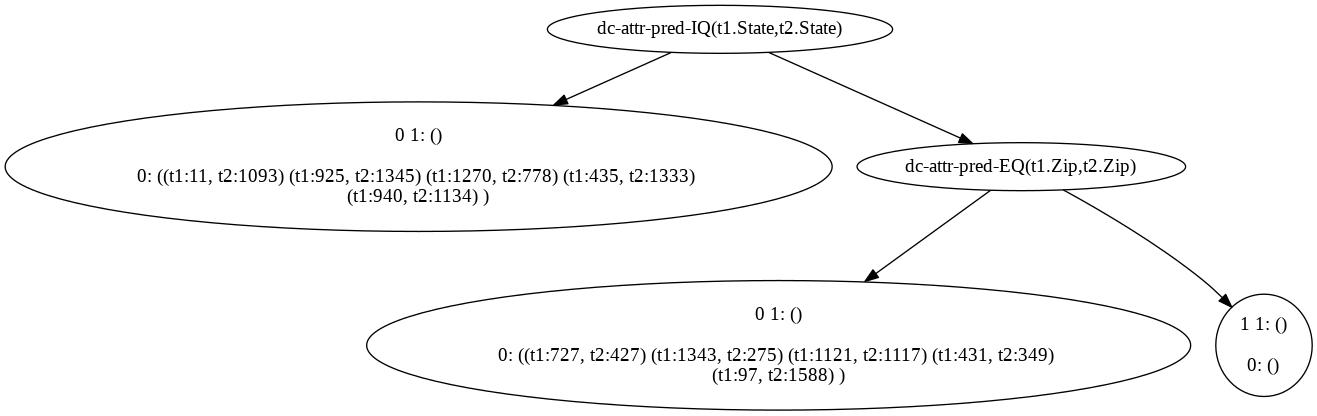



../experiment_results_folders/dc_test_case1004/20231010043455/tree_5_dot_file


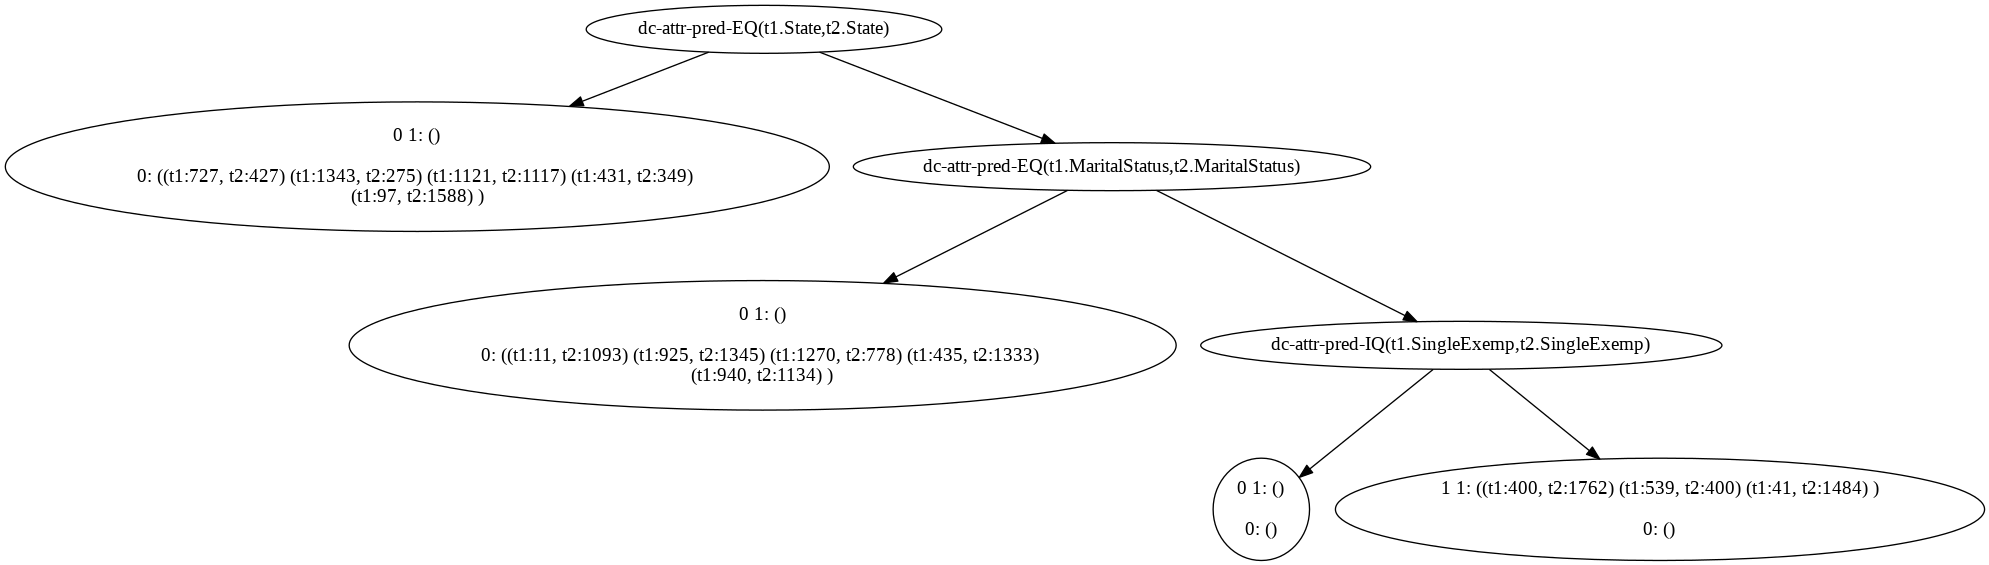



../experiment_results_folders/dc_test_case1004/20231010043455/tree_6_dot_file


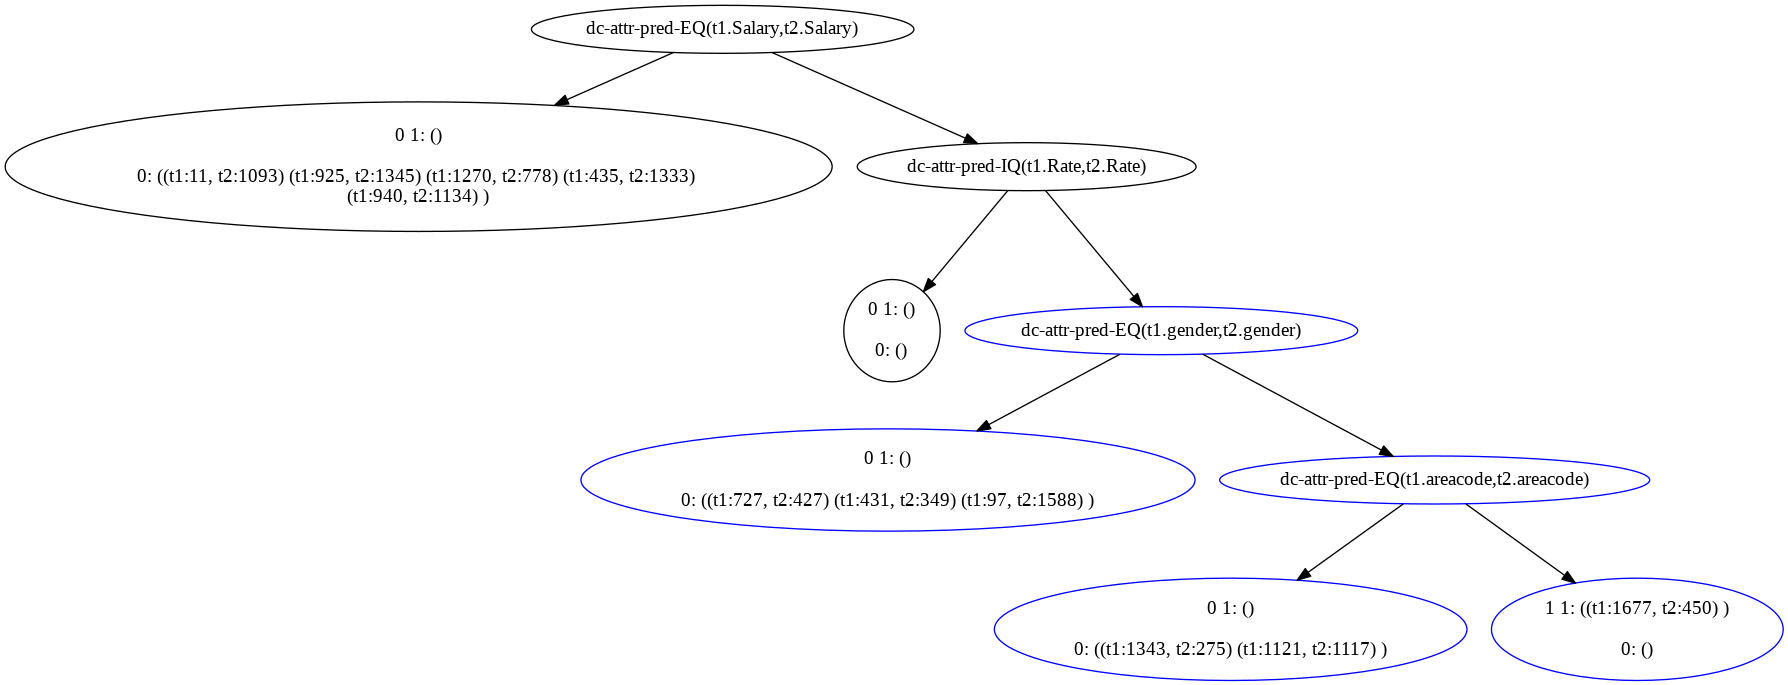



../experiment_results_folders/dc_test_case1004/20231010043455/tree_7_dot_file


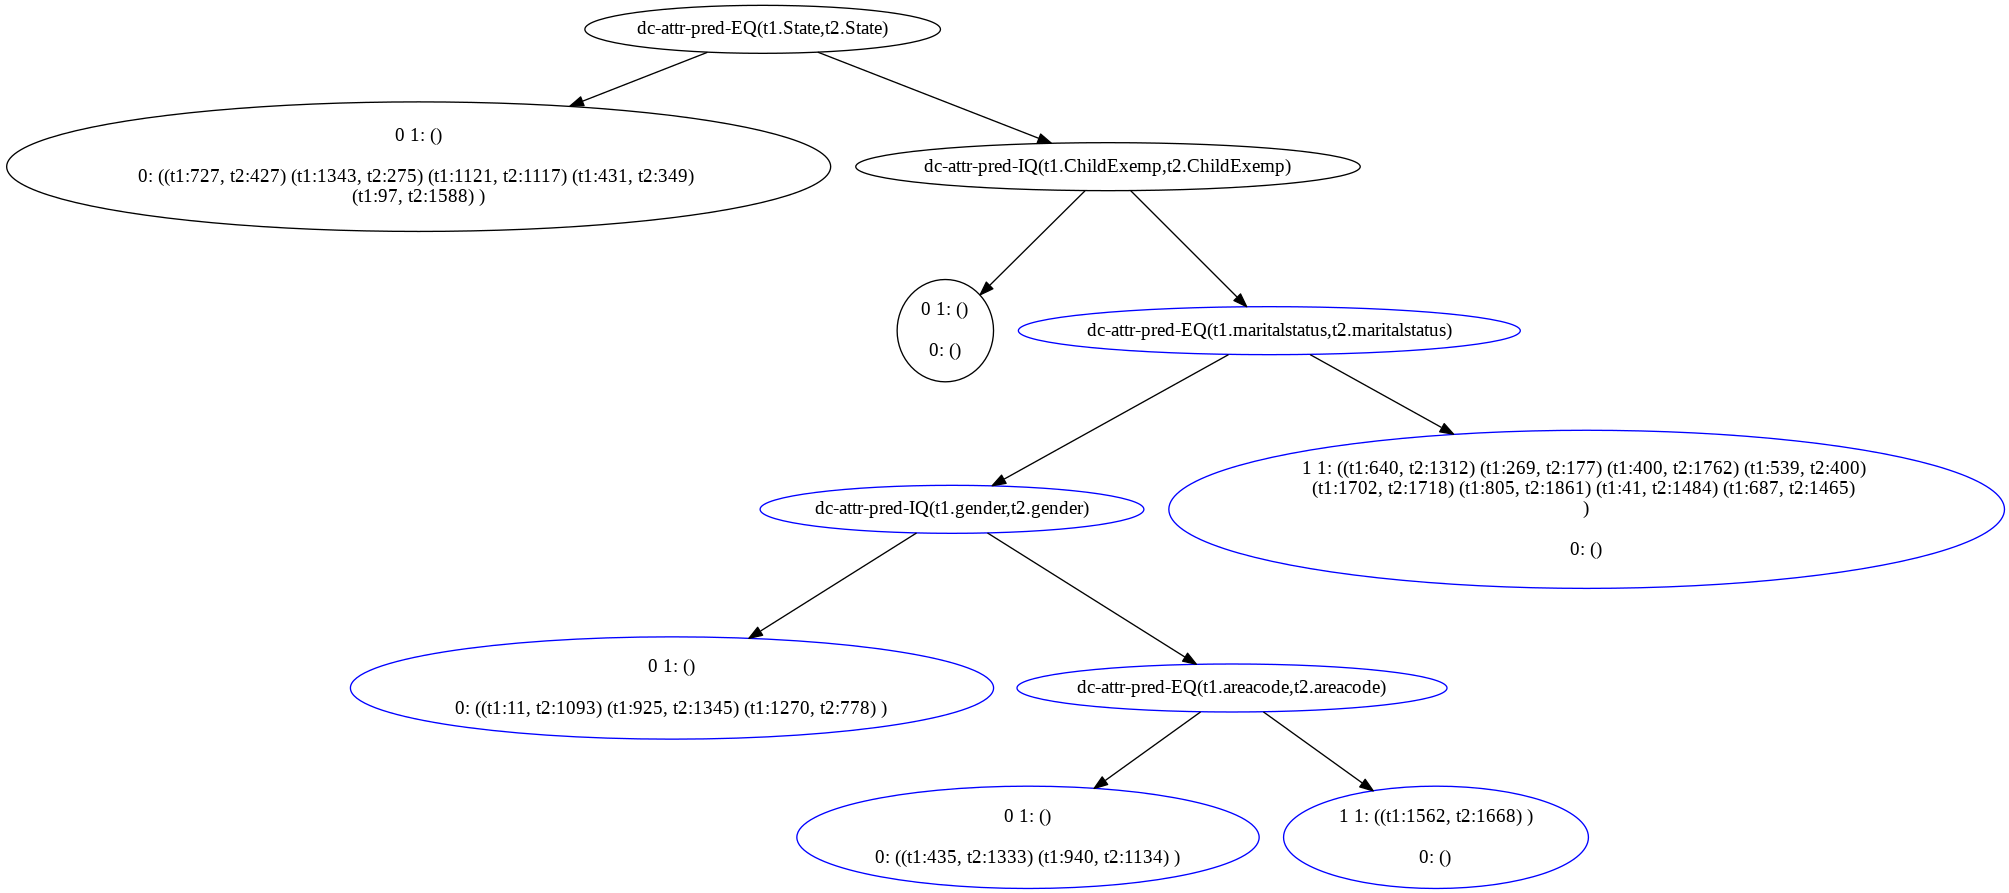

In [29]:
show_trees('../experiment_results_folders/dc_test_case1004/20231010043455/')

In [26]:
df_naive

,fname,lname,gender,areacode,phone,city,state,zip,maritalstatus,haschild,salary,rate,singleexemp,marriedexemp,childexemp,_tid_,is_dirty,type
0,Magne,Balard,F,501,1005272,WARM SPRINGS,AR,72478,M,N,82000,7.000000,0,40,0,11,False,complaint
1,Aarron,Roetter,F,509,1001090,WALDRON,WA,98297,S,Y,58500,0.000000,0,0,0,97,False,complaint
2,Senro,Exarkhopoulo,F,832,1000142,HOUSTON,TX,77221,M,N,85500,0.000000,0,0,0,431,False,complaint
3,Masashi,Lauchli,F,248,1001096,VERMONTVILLE,MI,49096,S,Y,16000,3.900000,3100,0,3100,435,False,complaint
4,Hyung,Nahapetian,F,641,1002382,SWEA CITY,IA,50590,S,Y,89000,8.980000,40,0,40,727,False,complaint
5,Sandiway,Mostrel,F,803,1003914,BLACKSTOCK,SC,29014,S,Y,58500,7.000000,3300,0,3300,925,False,complaint
6,Mabo,Towheed,M,918,1004210,LINDSAY,OK,73052,M,N,8000,4.972222,0,2000,0,940,False,complaint
7,Hideho,Pouffary,M,351,1000577,EAST BRIDGEWATER,MA,2333,M,N,32500,5.300000,0,7150,0,1121,False,complaint
8,Toshiki,Reutenauer,M,801,1002596,SALT LAKE CITY,UT,84134,M,N,54000,7.000000,0,4950,0,1270,False,complaint
9,Enrique,Gartshore,F,216,1000636,CLINTON,OH,44216,S,Y,78000,3.135226,1300,0,1300,1343,False,complaint
